# Deep dive

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import simpson
from scipy.stats import iqr
from astropy.stats import scott_bin_width, knuth_bin_width, freedman_bin_width, bayesian_blocks
import matplotlib.pyplot as plt
from importlib import reload
from bhad import model, utils

In [76]:
grid = np.linspace(-4,4,100)

N = 5*10**3

# Draw a sample via Accept/Reject sampling:
#-------------------------------------------
y = utils.rbartsim(MCsim = N, seed = None, verbose = True)

gamma_grid = np.linspace(1e-4,1-1e-4, 50)

# Square root choice:
h_sq = np.ceil(np.sqrt(N))
prior_max_M = min(int(0.3*N), int(h_sq))
#print(prior_max_M)   # https://en.wikipedia.org/wiki/Histogram

#----------------------------------------------------------------------------
log_marg_prior_nbins = {}
for m in range(1, prior_max_M, 1):
    
    prior = np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid])

    area = simpson(utils.exp_normalize(prior), gamma_grid)
    #area = simpson(prior, gamma_grid)
    
    log_marg_prior_nbins[m] = np.log(1e-10 + area)

log_marg_post = {m : log_marg_prior_nbins[m] + utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}
#log_marg_post = {m : utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}   # uniform prior

# Compute K_MAP for each feature:
#---------------------------------
opt_M = max(log_marg_post, key=log_marg_post.get)
print(opt_M)

post = utils.exp_normalize(np.array(list(log_marg_post.values())))
lpost = list(log_marg_post.values())
xx = np.array(list(log_marg_post.keys()))

#-----------------------------
# Credible interval of number of bins:
#-------------------------------
sig_level = 0.05
upper = np.sum(np.cumsum(post) <= (1-(sig_level/2))) 
lower = np.sum(np.cumsum(post) <= sig_level/2)
median = np.sum(np.cumsum(post) <= 0.5)

#opt_M = np.argmax(post) + 1

#print(opt_M)
print((lower, median, upper))

Acceptance rate: 0.4736

38
(33, 37, 41)


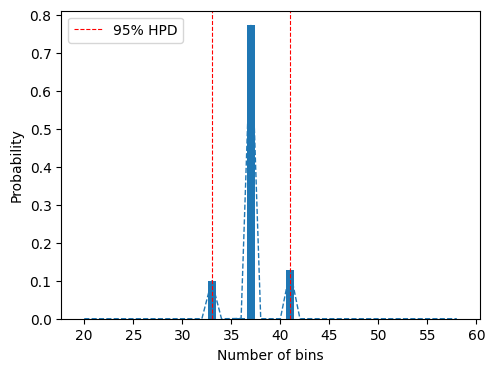

In [85]:
fig = plt.figure(figsize=(5.4,4))
ax = plt.axes()

#s = xx - 1
s = xx[(xx > 20) & (xx < 60)] - 1
#s = xx[(xx > 20)] - 1

#ax.plot(xx, post)
ax.plot(s, post[s], '--', linewidth=1)
#ax.bar(s, post)
ax.bar(s, post[s])
#ax.scatter(s, pr)
ax.axvline(x = lower, color = 'red',linestyle = '--', linewidth=0.8, label = f'{int((1-sig_level)*100)}% HPD')
ax.axvline(x = upper, color = 'red',linestyle = '--', linewidth=0.8)
ax.set_xlabel('Number of bins')
ax.set_ylabel('Probability')
ax.legend(loc="upper left")
#ax.set_title('Posterior mass function of K')
fig.savefig('post_k.png')   # save the figure to file
plt.show();
plt.close(fig)    # close the figure window

In [83]:
from scipy.stats import iqr
from astropy.stats import scott_bin_width, knuth_bin_width, freedman_bin_width, bayesian_blocks

N = len(y)

print(f'\nMAP number of bins: {opt_M}')

# Freedman-Diaconis rule:
bw = 2*iqr(y)*N**(-1/3)
FD = (max(y) - min(y))/bw
opt_fd = int(FD)
print(f'Freedman-Diaconis rule: {opt_fd}')

# Sturges:
opt_sturges = int(1 + 3.322*np.log(N))
print(f'Sturges rule: {opt_sturges}')

# Scott's normal reference rule:
#h = (3.49*np.std(y))/(N)**(1/3)     # bin width
h_scott = scott_bin_width(y)
opt_scott = int((max(y)-min(y))/h_scott)
print(f"Scotts rule: {opt_scott}")         # https://en.wikipedia.org/wiki/Histogram

# Square root choice:
#h_sq = np.ceil(np.sqrt(N))
#opt_sq = int(h_sq)
#print(int(h_sq))


# MAP with uniform prior on nbins:
h_knuth = knuth_bin_width(y)
opt_knuth = int((max(y)-min(y))/h_knuth)
#print(f"Knuths rule: {opt_knuth}")         # https://arxiv.org/pdf/physics/0605197.pdf



MAP number of bins: 38
Freedman-Diaconis rule: 33
Sturges rule: 26
Scotts rule: 27


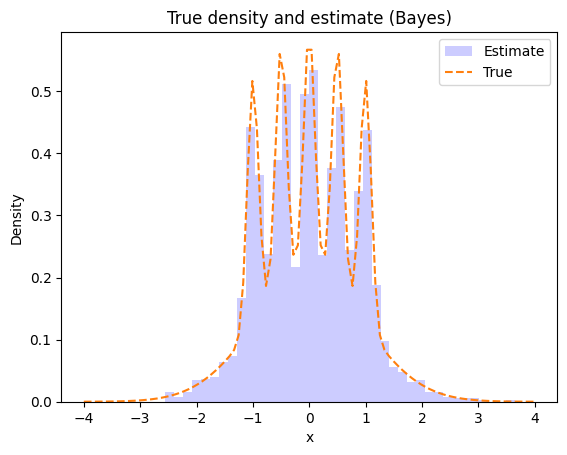

In [84]:
y_true = utils.bart_simpson_density(grid)

fig = plt.figure()

# create the histogram
counts1, bins1, patches1 = plt.hist(y, bins=opt_M + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Bayes'
#counts2, bins2, patches2 = plt.hist(y, bins=opt_fd + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Freedman-Diaconis'
#counts3, bins3, patches3 = plt.hist(y, bins=opt_sturges + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Sturges'
#counts4, bins4, patches4 = plt.hist(y, bins=opt_scott + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Scott'

plt.plot(grid, y_true, linestyle='dashed', label='True')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title(r'True density and estimate '+f"({main})")    #  with Bayes estimate number of bins
fig.savefig(f'est_Bart_{main}.png')   # save the figure to file

plt.show();
plt.close(fig)    # close the figure window

In [37]:

ord1, ord2, ord3, ord4 = [], [], [], []
for x in grid:
    
    if np.any(bins1 <= x):
        bucket_index1 = np.max(np.where(bins1 <= x))
        ord1.append(counts1[bucket_index1-1])
    else:
        ord1.append(counts1[0])

    if np.any(bins2 <= x):
        bucket_index2 = np.max(np.where(bins2 <= x))
        ord2.append(counts2[bucket_index2-1])
    else:
        ord2.append(counts2[0])

    if np.any(bins3 <= x):
        bucket_index3 = np.max(np.where(bins3 <= x))
        ord3.append(counts3[bucket_index3-1])
    else:
        ord3.append(counts3[0])
        
    if np.any(bins4 <= x):
        bucket_index4 = np.max(np.where(bins4 <= x))
        ord4.append(counts4[bucket_index4-1])
    else:
        ord4.append(counts4[0])

        
df = pd.DataFrame()
df['x'] = grid
#df['ytrue'] = y_true
df['mse1'] = (y_true-ord1)**2    # Bayes
df['mse2'] = (y_true-ord2)**2    # Freedman
df['mse3'] = (y_true-ord3)**2    # Sturges
df['mse4'] = (y_true-ord4)**2    # Scott

np.round(np.mean(df.values, axis=0)[1:],5)        

array([0.01099, 0.01383, 0.008  , 0.01207])

In [38]:
print(opt_M, opt_fd, opt_sturges, opt_scott)

23 17 21 13


In [41]:
from tqdm import tqdm 

def estimate_mise():

    grid = np.linspace(-4,4,100)     # grid of x-values
    grid_N = [10, 10**2, 10**3, 10**4, 10**5]
    y_true = utils.bart_simpson_density(grid)      # true/target density values!
    res = np.empty((len(grid_N), 4))

    for z, N in enumerate(tqdm(grid_N, total=len(grid_N))):
                
        # Draw a sample via Accept/Reject sampling:
        #-------------------------------------------
        y = utils.rbartsim(MCsim = N, seed = None, verbose = False)

        gamma_grid = np.linspace(1e-4,1-1e-4, 50)

        # Square root choice:
        h_sq = np.ceil(np.sqrt(N))
        prior_max_M = min(int(0.3*N), int(h_sq))
        #print(prior_max_M)   # https://en.wikipedia.org/wiki/Histogram
        #----------------------------------------------------------------------------
        log_marg_prior_nbins = {}
        for m in range(1, prior_max_M, 1):

            prior = np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid])

            area = simpson(utils.exp_normalize(prior), gamma_grid)
            #area = simpson(prior, gamma_grid)
            log_marg_prior_nbins[m] = np.log(1e-10 + area)

        log_marg_post = {m : log_marg_prior_nbins[m] + utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}
        #log_marg_post = {m : utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}   # uniform prior

        # Compute K_MAP for each feature:
        #---------------------------------
        opt_M = max(log_marg_post, key=log_marg_post.get)

        #print(f'\nMAP number of bins: {opt_M}')

        # Freedman-Diaconis rule:
        bw = 2*iqr(y)*N**(-1/3)
        FD = (max(y) - min(y))/bw
        opt_fd = int(FD)
        #print(f'Freedman-Diaconis rule: {opt_fd}')

        # Sturges:
        opt_sturges = int(1 + 3.322*np.log(N))
        #print(f'Sturges rule: {opt_sturges}')

        # Scott's normal reference rule:
        #h = (3.49*np.std(y))/(N)**(1/3)     # bin width
        h_scott = scott_bin_width(y)
        opt_scott = int((max(y)-min(y))/h_scott)
        #print(f"Scotts rule: {opt_scott}")         # https://en.wikipedia.org/wiki/Histogram

        # Square root choice:
        #h_sq = np.ceil(np.sqrt(N))
        #opt_sq = int(h_sq)
        #print(int(h_sq))

        # MAP with uniform prior on nbins:
        #h_knuth = knuth_bin_width(y)
        #opt_knuth = int((max(y)-min(y))/h_knuth)
        #print(f"Knuths rule: {opt_knuth}")         # https://arxiv.org/pdf/physics/0605197.pdf

        # create the histogram
        counts1, bins1, patches1 = plt.hist(y, bins=opt_M + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Bayes'
        counts2, bins2, patches2 = plt.hist(y, bins=opt_fd + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Freedman-Diaconis'
        counts3, bins3, patches3 = plt.hist(y, bins=opt_sturges + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Sturges'
        counts4, bins4, patches4 = plt.hist(y, bins=opt_scott + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Scott'
        plt.close();
        #-------------------------------------------------------------------

        ord1, ord2, ord3, ord4 = [], [], [], []
        for x in grid:

            if np.any(bins1 <= x):
                bucket_index1 = np.max(np.where(bins1 <= x))
                ord1.append(counts1[bucket_index1-1])
            else:
                ord1.append(counts1[0])

            if np.any(bins2 <= x):
                bucket_index2 = np.max(np.where(bins2 <= x))
                ord2.append(counts2[bucket_index2-1])
            else:
                ord2.append(counts2[0])

            if np.any(bins3 <= x):
                bucket_index3 = np.max(np.where(bins3 <= x))
                ord3.append(counts3[bucket_index3-1])
            else:
                ord3.append(counts3[0])

            if np.any(bins4 <= x):
                bucket_index4 = np.max(np.where(bins4 <= x))
                ord4.append(counts4[bucket_index4-1])
            else:
                ord4.append(counts4[0])

        df = pd.DataFrame()
        df['x'] = grid
        df['mse1'] = (y_true-ord1)**2    # Bayes
        df['mse2'] = (y_true-ord2)**2    # Freedman
        df['mse3'] = (y_true-ord3)**2    # Sturges
        df['mse4'] = (y_true-ord4)**2    # Scott

        res[z,:] = np.round(np.mean(df.values, axis=0)[1:],5)
    return pd.DataFrame(res, index=grid_N, columns=['Bayes', 'Freedman', 'Sturges', 'Scott'])
    #return res

In [42]:
estimate_mise()

100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


,Bayes,Freedman,Sturges,Scott
10,0.18733,0.40482,3.97739,0.14369
100,0.03083,0.02252,0.02658,0.02758
1000,0.01411,0.01057,0.01765,0.01282
10000,0.01403,0.00838,0.01489,0.01522
100000,0.00294,0.00227,0.01351,0.00539


In [51]:
mc = estimate_mise()   # i=1
Msim = 30
for i in range(Msim):
    mc = mc + estimate_mise()

MISE = pd.DataFrame(mc.values/(1+Msim), index=mc.index, columns=['Bayes', 'Freedman', 'Sturges', 'Scott'])

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


In [88]:
MISE

,Bayes,Freedman,Sturges,Scott
10,2.827439,6.419966,53.198350,2.819482
100,0.044934,0.034404,0.041184,0.040835
1000,0.014002,0.015380,0.016192,0.012415
10000,0.009712,0.008512,0.014781,0.013847
100000,0.003515,0.002394,0.014644,0.005486


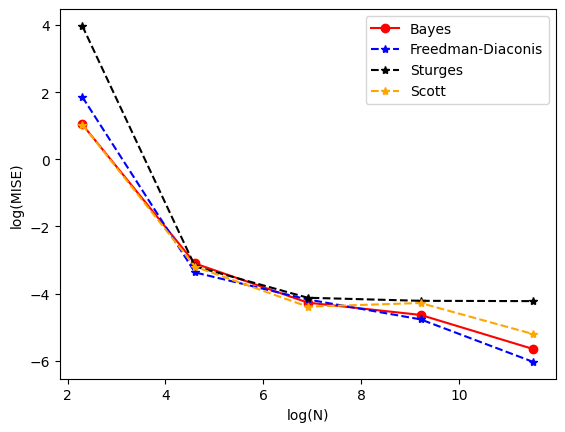

In [55]:
import matplotlib.pyplot as plt

plt.plot(np.log(MISE.index.values), np.log(MISE['Bayes'].values), '-o', color='red', label='Bayes')
plt.plot(np.log(MISE.index.values), np.log(MISE['Freedman'].values), '--*', color='blue', label='Freedman-Diaconis')
plt.plot(np.log(MISE.index.values), np.log(MISE['Sturges'].values), '--*', color='black', label='Sturges')
plt.plot(np.log(MISE.index.values), np.log(MISE['Scott'].values), '--*', color='orange', label='Scott')
plt.ylabel("log(MISE)")
plt.xlabel("log(N)")
#plt.title('Mean Integrated Squared Errors')
#plt.plot(MISE.index.values, MISE['Bayes'], '-o', color='red', label='Bayes')
#plt.plot(MISE.index.values, MISE['Freedman'], '--*', color='blue', label='Freedman-Diaconis')
#plt.plot(MISE.index.values, MISE['Sturges'], '--*', color='black', label='Sturges')
#plt.plot(MISE.index.values, MISE['Scott'], '--*', color='orange', label='Scott')

plt.legend()
#plt.savefig('MISE.png')   # save the figure to file
plt.show();
plt.close(fig)    # close the figure window

In [95]:
# Overall MISE:
pd.DataFrame(np.round(np.mean(MISE.values, axis=0),5), index=['Bayes', 'Freedman', 'Sturges', 'Scott']).T

,Bayes,Freedman,Sturges,Scott
0,0.57992,1.29613,10.65703,0.57841
